### Surface signal for 8Tr in Astoria and Barkley bathymetries

In [1]:
import cmocean as cmo
from netCDF4 import Dataset
import matplotlib.pyplot as plt
import matplotlib as mpl
%matplotlib inline
import numpy as np
import pandas as pd
import seaborn as sns
import canyon_tools.readout_tools as rout
import canyon_tools.savitzky_golay as sg

import matplotlib.gridspec as gspec

In [2]:
from IPython.display import HTML

HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')


In [3]:
sns.set_context('notebook')
sns.set_style('whitegrid')

In [55]:
def PlotSurfTr(ax1, ax2, tt, key, ptr_fileA, ptr_fileB, ptr_fileANoC, ptr_fileBNoC, grid_fileA, grid_fileB,
                xslice_pl, yslice_pl, nz,
                hFacA, rAA, DepthA, XA, YA,
                hFacB, rAB, DepthB, XB, YB, sbdepthA=-150, sbdepthB=-200, vmin=-0.2, vmax=0.2):
    
    sns.set_style('white')
    with Dataset(ptr_fileA, 'r') as nbl:
        ConcLinA = np.mean(nbl.variables[key][tt,:4,:,:], axis=0)
    with Dataset(ptr_fileANoC, 'r') as nbl:
        ConcLinANoC = np.mean(nbl.variables[key][tt,:4,:,:], axis=0)
        
    mesh1 = ax1.contourf(XA, YA, (ConcLinA-ConcLinANoC)/ConcLinANoC,20,
                        cmap=cmo.cm.tarn_r, vmin=vmin, vmax=vmax)

    plt.colorbar(mesh1, ax=ax1)
    
    with Dataset(grid_fileA, 'r') as nbl:
        bathy = nbl.variables['Depth'][:]
    ax1.contour(XA, YA, bathy,levels=[-sbdepthA],colors=['0.4'])

    with Dataset(ptr_fileB, 'r') as nbl:
        ConcLinB = np.mean(nbl.variables[key][tt,:4,:,:], axis=0)
    with Dataset(ptr_fileBNoC, 'r') as nbl:
        ConcLinBNoC = np.mean(nbl.variables[key][tt,:4,:,:], axis=0)
        
    mesh2 = ax2.contourf(XB, YB, (ConcLinB-ConcLinBNoC)/ConcLinBNoC, 20,
                        cmap=cmo.cm.tarn_r, vmin=vmin, vmax=vmax)

    plt.colorbar(mesh2, ax=ax2)
    
    with Dataset(grid_fileB, 'r') as nbl:
        bathyB = nbl.variables['Depth'][:]
    ax2.contour(XB, YB, bathyB,levels=[-sbdepthB],colors=['0.4'])
   
    for ax in [ax1,ax2]:
        ax.set_facecolor("darkgrey")
        ax.set_ylabel('Cross-shelf / km')

    ax1.set_xlabel('CS distance / km')
    ax1.set_title('Astoria')
    ax2.set_xlabel('CS distance / km')
    ax2.set_title('Barkley day %1.1f' %(tt/2))

    ax1.set_aspect(1)
    return(ax1, ax2)



In [5]:
ptr_fileB = '/data/kramosmu/results/TracerExperiments/UPW_8TR_BF4_BAR/01_Bar03/ptracersGlob.nc'
grid_fileB = '/data/kramosmu/results/TracerExperiments/UPW_8TR_BF4_BAR/01_Bar03/gridGlob.nc'
ptr_fileBNoC = '/data/kramosmu/results/TracerExperiments/UPW_8TR_BF4_BAR/02_Bar03_No_Cny/ptracersGlob.nc'

ptr_fileA = '/data/kramosmu/results/TracerExperiments/UPW_8TR_BF2_AST/01_Ast03/ptracersGlob.nc'
grid_fileA = '/data/kramosmu/results/TracerExperiments/UPW_8TR_BF2_AST/01_Ast03/gridGlob.nc'
ptr_fileANoC = '/data/kramosmu/results/TracerExperiments/UPW_8TR_BF2_AST/02_Ast03_No_Cny/ptracersGlob.nc'

In [6]:
nz = 104
sb_Ast = 30 # shelf break z-index Astoria
sb_Bar = 40 # shelf break z-index Barkley

with Dataset(grid_fileB, 'r') as nbl:
    ZB = nbl.variables['RC'][:]
    YB = nbl.variables['Y'][:]
    XB = nbl.variables['X'][:]
    hFacB = nbl.variables['HFacC'][:]
    DepthB = nbl.variables['Depth'][:]
    hfac = np.ma.masked_values(hFacB, 0)
    maskCB = np.ma.getmask(hfac)
    rAB = nbl.variables['rA'][:]
    
with Dataset(grid_fileA, 'r') as nbl:
    ZA = nbl.variables['RC'][:]
    YA = nbl.variables['Y'][:]
    XA = nbl.variables['X'][:]
    hFacA = nbl.variables['HFacC'][:]
    DepthA = nbl.variables['Depth'][:]
    hfac = np.ma.masked_values(hFacA, 0)
    maskCA = np.ma.getmask(hfac)
    rAA = nbl.variables['rA'][:]

### 01 - Initial profiles

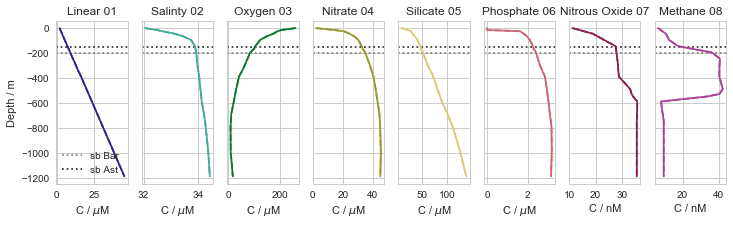

In [7]:
tracers = ['Tr01','Tr02','Tr03','Tr04','Tr05','Tr06','Tr07','Tr08']
labels = ['Linear 01','Salinty 02','Oxygen 03','Nitrate 04','Silicate 05','Phosphate 06','Nitrous Oxide 07','Methane 08']
#colours = ['purple','blue','green','gold','orange','red','orchid','teal']
colours = ['#332288','#44AA99','#117733','#999933','#DDCC77','#CC6677','#882255','#AA4499']
fig,ax = plt.subplots(1,len(tracers),figsize=(12,3), sharey = True)
    
for ii, trac, col, lab in zip(range(len(tracers)),tracers , colours, labels):

    ax[ii].axhline(-200, linestyle=':', color='0.5', label='sb Bar')
    ax[ii].axhline(-150, linestyle=':', color='0.2', label='sb Ast')
    
    for pfile, Z, style in zip([ptr_fileB, ptr_fileA],[ZB, ZA],['-', '--']):
        
        with Dataset(pfile, 'r') as nbl:
            tr_profile = nbl.variables[trac][0,:,10,180]

        ax[ii].plot(tr_profile, Z, color=col,linestyle=style)
        ax[ii].set_title(lab)
        
        if (trac == 'Tr07' or trac == 'Tr08'):
            ax[ii].set_xlabel('C / nM')
        else:
            ax[ii].set_xlabel(r'C / $\mu$M')

ax[0].set_ylabel('Depth / m')        
ax[0].legend(loc=0)

Initial profiles. Profiles for both runs plotted to check they are actually the same.

#### Vertical tracer gradient

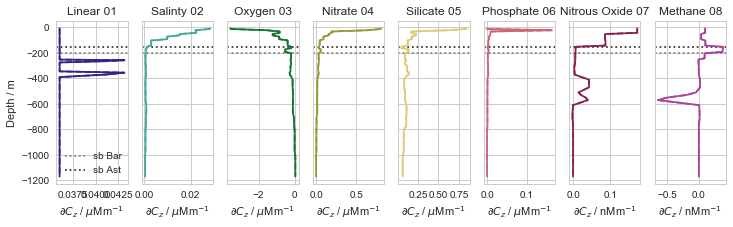

In [8]:
tracers = ['Tr01','Tr02','Tr03','Tr04','Tr05','Tr06','Tr07','Tr08']
labels = ['Linear 01','Salinty 02','Oxygen 03','Nitrate 04','Silicate 05','Phosphate 06','Nitrous Oxide 07','Methane 08']

dTr_Ast = np.empty(len(tracers))
dTr_Bar = np.empty(len(tracers))

fig,ax = plt.subplots(1,len(tracers),figsize=(12,3), sharey = True)
    
for ii, trac, col, lab in zip(range(len(tracers)),tracers , colours, labels):

    ax[ii].axhline(-200, linestyle=':', color='0.5', label='sb Bar')
    ax[ii].axhline(-150, linestyle=':', color='0.2', label='sb Ast')
    
    for pfile, Z, style in zip([ptr_fileB, ptr_fileA],[ZB, ZA],['-', '--']):
        
        with Dataset(pfile, 'r') as nbl:
            tr_profile = nbl.variables[trac][0,:,10,180]
            dTrdz = (tr_profile[2:]-tr_profile[:-2])/(-Z[2:]+Z[:-2])  
            dTr_Ast[ii] = dTrdz[sb_Ast]
            dTr_Bar[ii] = dTrdz[sb_Bar]
            
        ax[ii].plot(dTrdz, Z[1:-1], color=col,linestyle=style)
        ax[ii].set_title(lab)
        
        if (trac == 'Tr07' or trac == 'Tr08'):
            ax[ii].set_xlabel('$\partial C_z$ / nMm$^{-1}$')
        else:
            ax[ii].set_xlabel(r'$\partial C_z$ / $\mu$Mm$^{-1}$')

ax[0].set_ylabel('Depth / m')        
ax[0].legend(loc=0)

### 02 - Shelf-bottom pool 

Linear tracer (Tr01) 

Tracer gradients below shelf-break depth are the same for both canyons. This is the "base case" pool where both canyons have the same N,f, almost same U, and same dTr/dz at shelf-break depth.

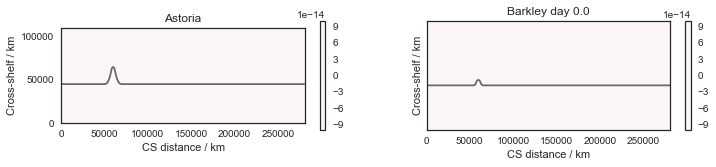

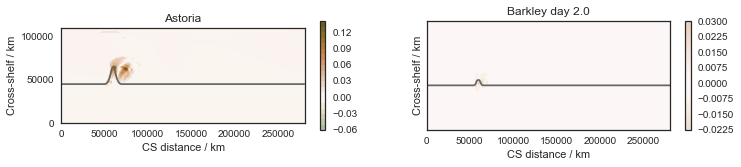

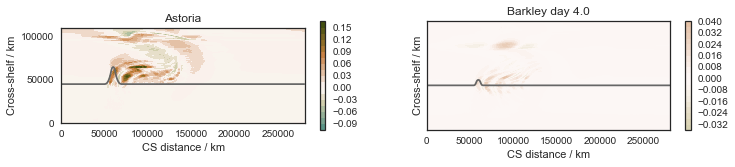

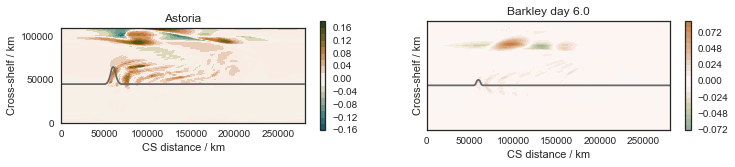

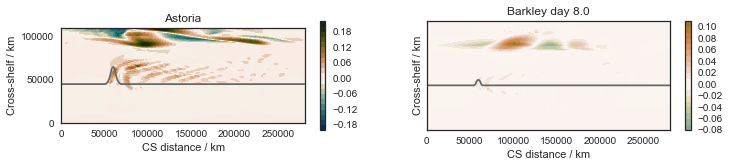

In [56]:
yslice_pl = slice(110,360)
xslice_pl = slice(120,500)

key = 'Tr01'

for tt in [0,4,8,12,16]:
    fig, (ax1,ax2) = plt.subplots(1,2,figsize=(12,2), sharey=True, sharex = True)
    
    ax1,ax2 = PlotSurfTr (ax1, ax2, tt, key, ptr_fileA, ptr_fileB, ptr_fileANoC, ptr_fileBNoC, grid_fileA, grid_fileB,
                          xslice_pl, yslice_pl, nz,
                          hFacA, rAA, DepthA, XA, YA,
                          hFacB, rAB, DepthB, XB, YB, sbdepthA=-150, sbdepthB=-200)
    

Salinity (Tr02)

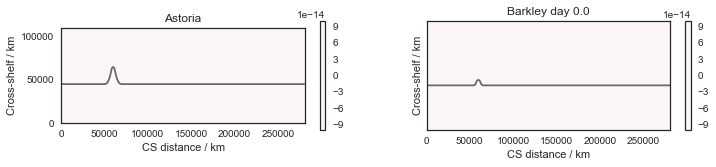

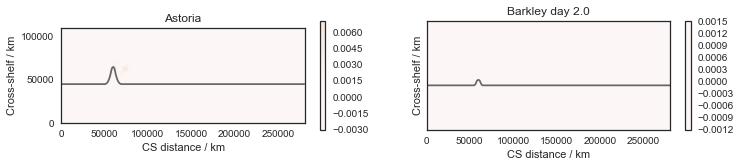

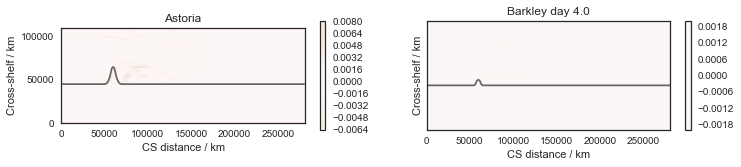

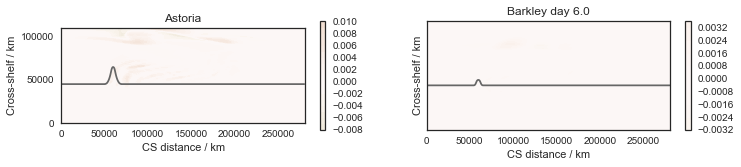

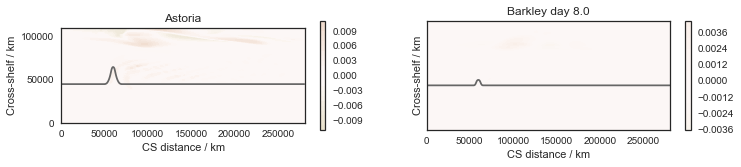

In [57]:
yslice_pl = slice(110,360)
xslice_pl = slice(120,500)

key = 'Tr02'

for tt in [0,4,8,12,16]:
    fig, (ax1,ax2) = plt.subplots(1,2,figsize=(12,2), sharey=True, sharex = True)
    
    ax1,ax2 = PlotSurfTr (ax1, ax2, tt, key, ptr_fileA, ptr_fileB, ptr_fileANoC, ptr_fileBNoC,grid_fileA, grid_fileB,
                          xslice_pl, yslice_pl, nz,
                          hFacA, rAA, DepthA, XA, YA,
                          hFacB, rAB, DepthB, XB, YB, sbdepthA=-150, sbdepthB=-200, vmin=-0.1, vmax=0.1)
  

#### Oxygen

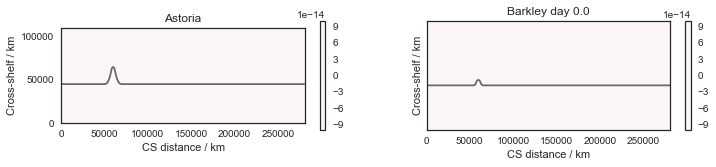

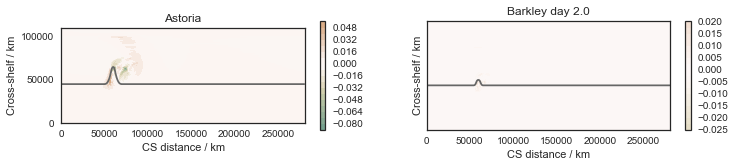

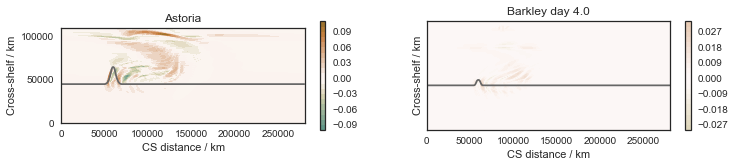

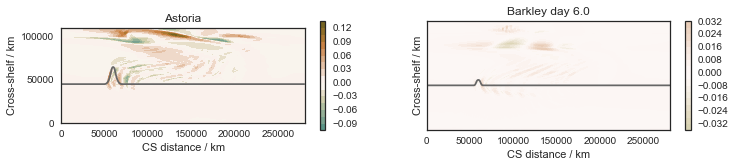

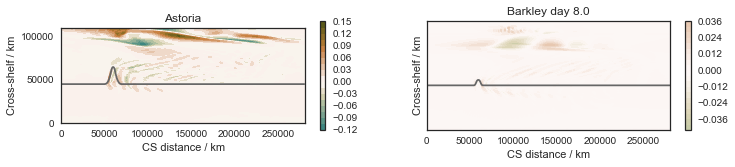

In [58]:
yslice_pl = slice(110,360)
xslice_pl = slice(120,500)

key = 'Tr03'

for tt in [0,4,8,12,16]:
    fig, (ax1,ax2) = plt.subplots(1,2,figsize=(12,2), sharey=True, sharex = True)
    
    ax1,ax2 = PlotSurfTr (ax1, ax2, tt, key, ptr_fileA, ptr_fileB, ptr_fileANoC, ptr_fileBNoC,grid_fileA, grid_fileB,
                          xslice_pl, yslice_pl, nz,
                          hFacA, rAA, DepthA, XA, YA,
                          hFacB, rAB, DepthB, XB, YB, sbdepthA=-150, sbdepthB=-200)
  

#### Nitrate

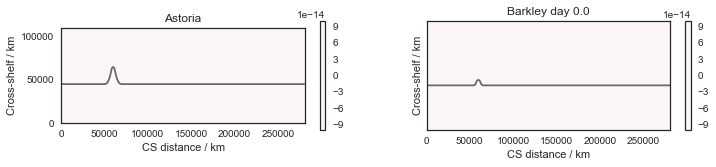

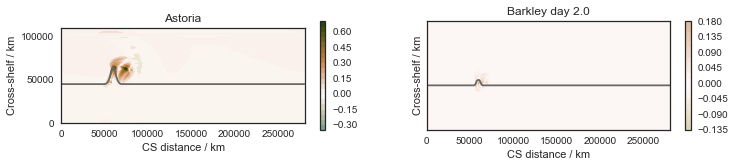

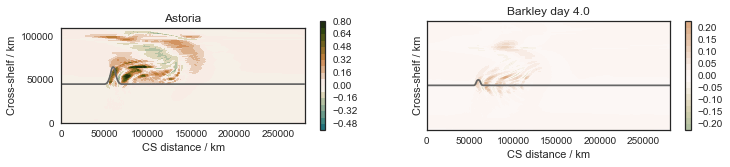

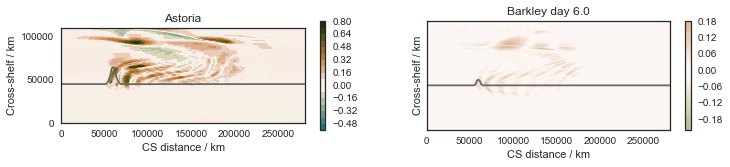

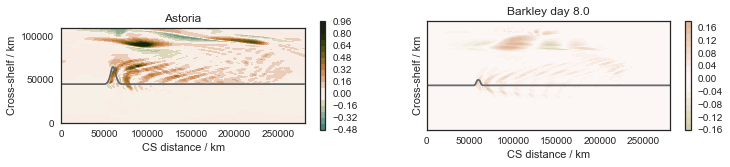

In [59]:
yslice_pl = slice(110,360)
xslice_pl = slice(120,500)

key = 'Tr04'

for tt in [0,4,8,12,16]:
    fig, (ax1,ax2) = plt.subplots(1,2,figsize=(12,2), sharey=True, sharex = True)
    
    ax1,ax2 = PlotSurfTr (ax1, ax2, tt, key, ptr_fileA, ptr_fileB, ptr_fileANoC, ptr_fileBNoC,grid_fileA, grid_fileB,
                          xslice_pl, yslice_pl, nz,
                          hFacA, rAA, DepthA, XA, YA,
                          hFacB, rAB, DepthB, XB, YB, sbdepthA=-150, sbdepthB=-200, vmin=-0.8, vmax=0.8)
  

#### Silicate

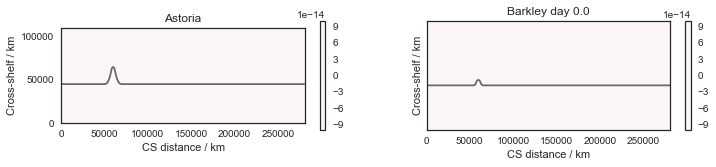

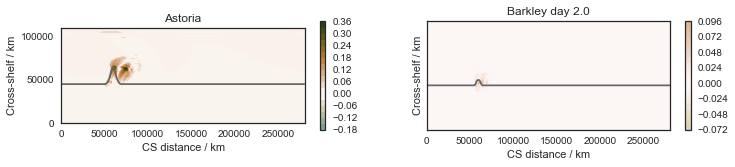

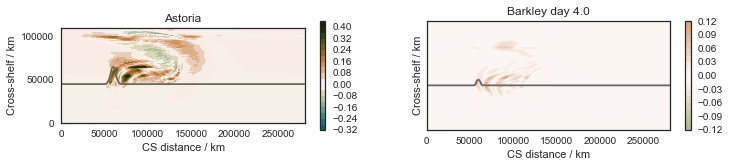

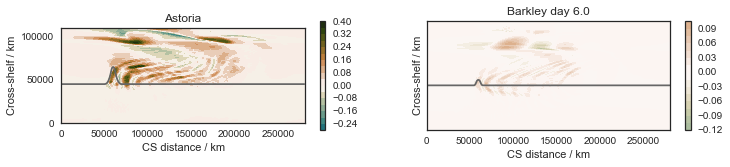

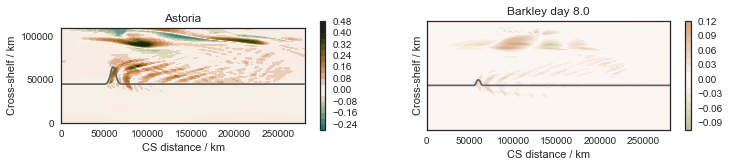

In [60]:
yslice_pl = slice(110,360)
xslice_pl = slice(120,500)

key = 'Tr05'

for tt in [0,4,8,12,16]:
    fig, (ax1,ax2) = plt.subplots(1,2,figsize=(12,2), sharey=True, sharex = True)
    
    ax1,ax2 = PlotSurfTr (ax1, ax2, tt, key, ptr_fileA, ptr_fileB, ptr_fileANoC, ptr_fileBNoC,grid_fileA, grid_fileB,
                          xslice_pl, yslice_pl, nz,
                          hFacA, rAA, DepthA, XA, YA,
                          hFacB, rAB, DepthB, XB, YB, sbdepthA=-150, sbdepthB=-200, vmin=-0.4, vmax=0.4)
  

#### Phosphate - dividing by a small number is baaad. See bottom plots

/home/kramosmu/anaconda3/lib/python3.5/site-packages/numpy/ma/core.py:4144: UserWarning: Warning: converting a masked element to nan.
  warnings.warn("Warning: converting a masked element to nan.")


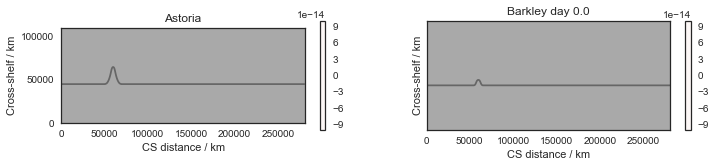

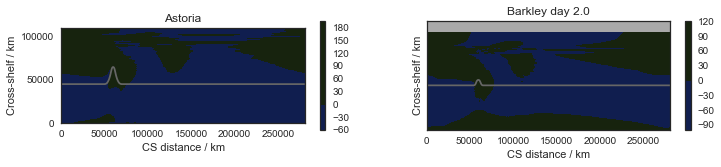

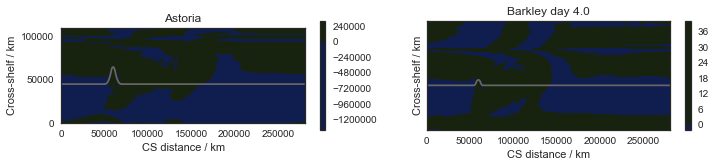

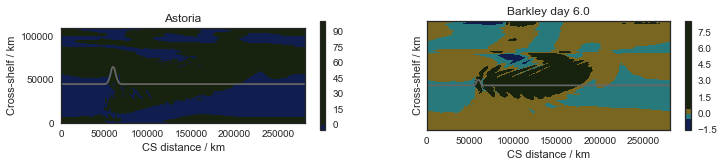

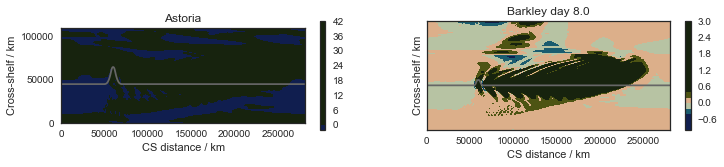

In [61]:
yslice_pl = slice(110,360)
xslice_pl = slice(120,500)

key = 'Tr06'

for tt in [0,4,8,12,16]:
    fig, (ax1,ax2) = plt.subplots(1,2,figsize=(12,2), sharey=True, sharex = True)
    
    ax1,ax2 = PlotSurfTr (ax1, ax2, tt, key, ptr_fileA, ptr_fileB, ptr_fileANoC, ptr_fileBNoC,grid_fileA, grid_fileB,
                          xslice_pl, yslice_pl, nz,
                          hFacA, rAA, DepthA, XA, YA,
                          hFacB, rAB, DepthB, XB, YB, sbdepthA=-150, sbdepthB=-200, vmin=-0.4, vmax=0.4)
 

#### Nitrous Oxide

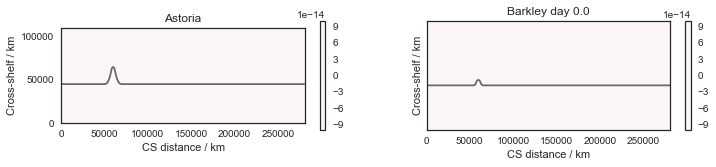

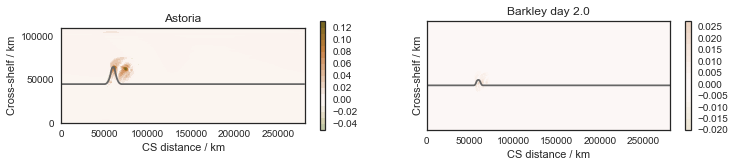

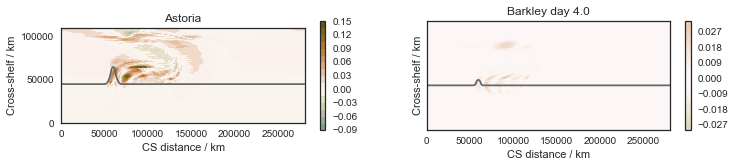

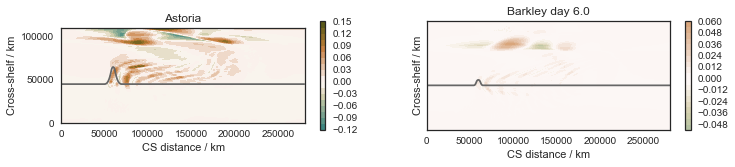

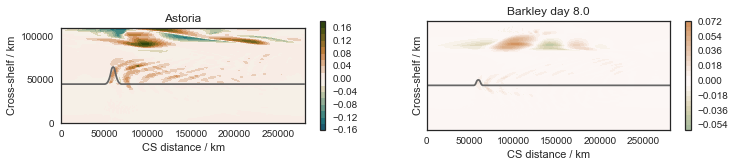

In [62]:
yslice_pl = slice(110,360)
xslice_pl = slice(120,500)

key = 'Tr07'

for tt in [0,4,8,12,16]:
    fig, (ax1,ax2) = plt.subplots(1,2,figsize=(12,2), sharey=True, sharex = True)
    
    ax1,ax2 = PlotSurfTr (ax1, ax2, tt, key, ptr_fileA, ptr_fileB, ptr_fileANoC, ptr_fileBNoC,grid_fileA, grid_fileB,
                          xslice_pl, yslice_pl, nz,
                          hFacA, rAA, DepthA, XA, YA,
                          hFacB, rAB, DepthB, XB, YB, sbdepthA=-150, sbdepthB=-200, vmin=-0.2, vmax=0.2)
  

#### Methane

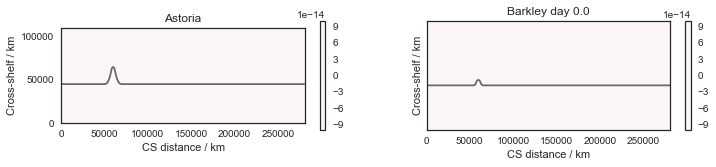

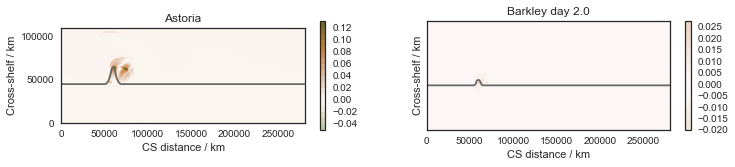

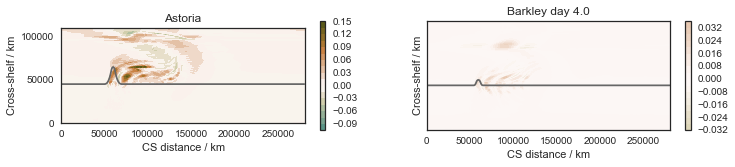

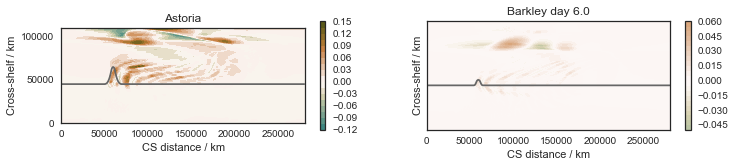

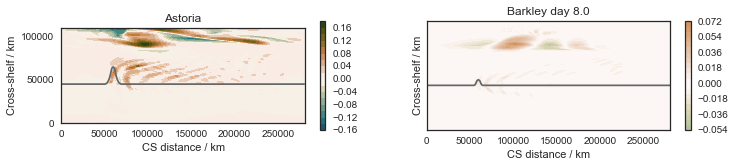

In [63]:
yslice_pl = slice(110,360)
xslice_pl = slice(120,500)

key = 'Tr08'

for tt in [0,4,8,12,16]:
    fig, (ax1,ax2) = plt.subplots(1,2,figsize=(12,2), sharey=True, sharex = True)
    
    ax1,ax2 = PlotSurfTr (ax1, ax2, tt, key, ptr_fileA, ptr_fileB, ptr_fileANoC, ptr_fileBNoC,grid_fileA, grid_fileB,
                          xslice_pl, yslice_pl, nz,
                          hFacA, rAA, DepthA, XA, YA,
                          hFacB, rAB, DepthB, XB, YB, sbdepthA=-150, sbdepthB=-200, vmin=-0.2, vmax=0.2)
  

#### Phosphate anomaly (without rescaling because initial concentrations are very small)

Text(0.5,1,'canyon-no canyon, Anomaly / $\\mu$M')

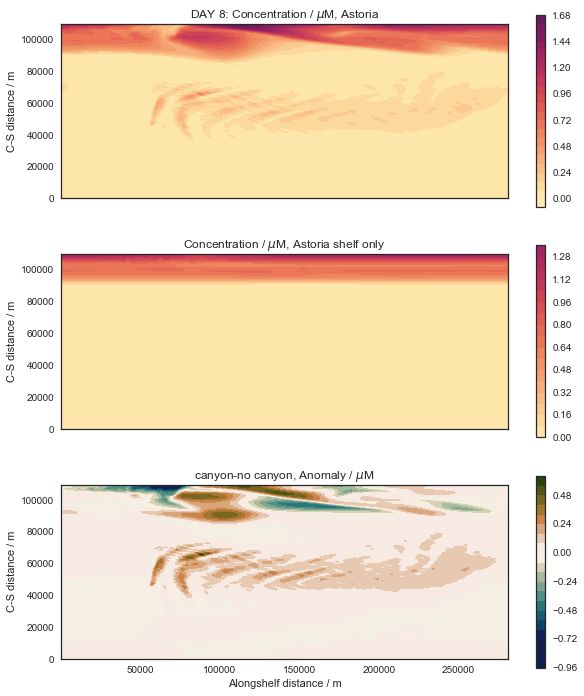

In [64]:
fig,(ax1, ax2, ax3) = plt.subplots(3,1,figsize=(10,12), sharex=True) 

key = 'Tr06'
tt = 16
with Dataset(ptr_fileA, 'r') as nbl:
    ConcLinA = np.mean(nbl.variables[key][tt,:4,:,:], axis=0)

mesh1 = ax1.contourf(XA, YA, ConcLinA,20,
                     cmap=cmo.cm.matter, vmin=0, vmax=2)
plt.colorbar(mesh1, ax=ax1)
    
with Dataset(ptr_fileANoC, 'r') as nbl:
    ConcLinANoC = np.mean(nbl.variables[key][tt,:4,:,:], axis=0)

mesh2 = ax2.contourf(XA, YA, ConcLinANoC,20,
                     cmap=cmo.cm.matter, vmin=0, vmax=2)
plt.colorbar(mesh2, ax=ax2)

mesh3 = ax3.contourf(XA, YA, (ConcLinA-ConcLinANoC),20,
                     cmap=cmo.cm.tarn_r, vmin=-0.7, vmax=0.7)
plt.colorbar(mesh3, ax=ax3)

ax1.set_aspect(1)        
ax2.set_aspect(1)        
ax3.set_aspect(1)        

ax3.set_xlabel('Alongshelf distance / m')
ax1.set_ylabel('C-S distance / m')
ax2.set_ylabel('C-S distance / m')
ax3.set_ylabel('C-S distance / m')

ax1.set_title('DAY 8: Concentration / $\mu$M, Astoria')
ax2.set_title('Concentration / $\mu$M, Astoria shelf only')
ax3.set_title('canyon-no canyon, Anomaly / $\mu$M')

### Take-aways

* Barkley's near-surface anomaly signal is weaker than for Astoria for all tracers. Barkely's shelf break is 50 m deeper than Astoria's.

* For all tracers, positive-negative anomaly band close to northern boundary, where depth is 20m. In Barkley, the signal is weaker and closer to shelf break, where bathy becomes 20 m.

* For all tracers, positive anomaly above canyon location that travels downstream. Can be as large as 80% for nitrate in Astoria but around 20% for other tracers. Positive-negative bands for Oxygen.

ADD PROFILES!!